# Upcoming Birbs

I did a quick bit of measuring, and am thinking that it may be possible to do this with a boring old camera for the first pass.  This is a bit of pass planning for that purpose.  Let's find all the satellites that are going to be in view during the next few evenings during a few hours.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import ephem

qth = ephem.Observer()
qth.lat = np.deg2rad(37.7282)
qth.lon = np.deg2rad(-122.4070)
qth.elevation = 25

Now, let's just load up the TLE data that gpredict has stashed for us:

In [3]:
import glob
import ConfigParser # INI Files, yay!

def sat_to_body(path):
    cp = ConfigParser.RawConfigParser()
    cp.read(path)
    secname = 'Satellite'
    name = cp.get(secname, 'name')
    tle1 = cp.get(secname, 'TLE1')
    tle2 = cp.get(secname, 'TLE2')
    return ephem.readtle(name, tle1, tle2)

satellites = {} # SSN => PyEphem object

for p in glob.glob("/home/jbm/.config/Gpredict/satdata/*.sat"):
    ssn = int(p[p.rindex('/')+1:-4])
    satellites[ssn] = sat_to_body(p)
    
len(satellites)

2220

## Plotting our plotting
First, let's get our polar plotting in order, to make things easier to reason about.  Then we'll see what's in the sky right now, because why not really.

In [5]:
def az2polar(az):
    return np.pi/2 - az

def alt2polar(alt):
    return np.pi/2 - alt

def alt2polardeg(alt):
    return np.rad2deg(alt2polar(alt))

In [6]:
import datetime

In [12]:
dt = datetime.datetime.strptime("2017-12-01 01:00:00 UTC", "%Y-%m-%d %H:%M:%S %Z", )
dt.tzinfo()

TypeError: 'NoneType' object is not callable

In [28]:
import pytz

In [65]:
dt0 = datetime.datetime(2017, 12, 1, 1, 0, 0, 0, pytz.UTC)

time_window = (dt0, dt0+datetime.timedelta(hours=4))
time_step = datetime.timedelta(seconds=30)

az_range = (0, np.deg2rad(120)) # headings
alt_range = (np.deg2rad(15), np.deg2rad(65)) # can only see this through the window

max_elevation = 10000000 # maximum satellite elevation: skip GEO birds.
max_elevation =  1000000  # max elevation: skip very distant birds

qth = ephem.Observer()
qth.lat = np.deg2rad(37.7282)
qth.lon = np.deg2rad(-122.4070)
qth.elevation = 25

results = {} # day offset => list of visibles

n_exceptions = 0
n_comps = 0

for n_days in [0]:
    day_offset = datetime.timedelta(days=n_days)
    dt_l = time_window[0] + day_offset
    dt_r = time_window[1] + day_offset
  
    visibles = []

    for ssn, o in satellites.iteritems():
        try:
            dt_now = dt_l
            qth.date = dt_now
            time_step_ssn = time_step

            o.compute(qth)

            if o.elevation > max_elevation:
                continue

            while dt_now < dt_r:
                qth.date = dt_now
                o.compute(qth)

                altp = o.alt
                azp = o.az
                n_comps += 1
                if az_range[0] < azp and azp < az_range[1] and alt_range[0] < altp and altp < alt_range[1]:
                    visibles.append((ssn, np.rad2deg(altp), np.rad2deg(azp), o.range, dt_now))
                    time_step_ssn = datetime.timedelta(seconds=1)
                else:
                    time_step_ssn = time_step
                dt_now += time_step_ssn

        except Exception, e:
            n_exceptions += 1
            pass
        
    results[n_days] = visibles
    
len(results[0]), n_comps

(52137, 522840)

Now, we want to figure out where the best place to put the camera is.  We have a 20°x14° field to work with, so we want to find the best window for that.

52 120


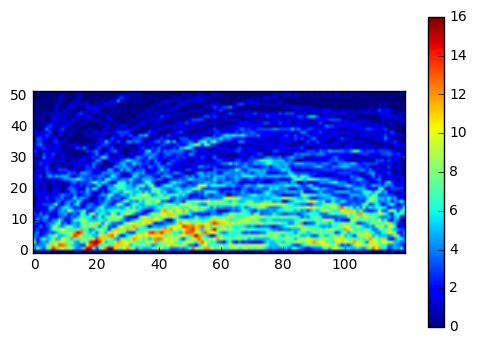

In [68]:
def _discdeg(x):
    return int(np.rad2deg(x))

az_degs = map(_discdeg, az_range)
alt_degs = map(_discdeg, alt_range)


az_span = az_degs[1] - az_degs[0] + 1 # for good measure
alt_span = alt_degs[1] - alt_degs[0] + 1
              
from collections import defaultdict

ssn_bins = defaultdict(set)    
    
for ssn, alt, az, rng, dt in results[0]:
    alt_i = int(alt)
    az_i = int(az)
    
    ssn_bins[(alt_i,az_i)].add(ssn)
    
print alt_span, az_span
bins = np.zeros((alt_span, az_span))
    
for b,s in ssn_bins.iteritems():
    bins[b[0]-alt_degs[0],b[1]-az_degs[0]] = len(s)
    
imshow(bins, origin="bottom")
colorbar()

Okay, so we want to point our camera at about NE at an elevation of about 15°.  That's not too hard.

52 120


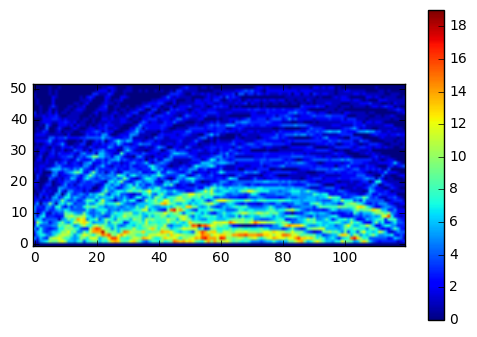

In [69]:
dt0 = datetime.datetime(2017, 12, 1, 1, 0, 0, 0, pytz.UTC)

time_window = (dt0, dt0+datetime.timedelta(hours=4))
time_step = datetime.timedelta(seconds=30)

az_range = (0, np.deg2rad(120)) # headings
alt_range = (np.deg2rad(15), np.deg2rad(65)) # can only see this through the window

max_elevation = 10000000 # maximum satellite elevation: skip GEO birds.
max_elevation =  1000000  # max elevation: skip very distant birds

qth = ephem.Observer()
qth.lat = np.deg2rad(37.7282)
qth.lon = np.deg2rad(-122.4070)
qth.elevation = 25

results = {} # day offset => list of visibles

n_exceptions = 0
n_comps = 0

for n_days in [1]:
    day_offset = datetime.timedelta(days=n_days)
    dt_l = time_window[0] + day_offset
    dt_r = time_window[1] + day_offset
  
    visibles = []

    for ssn, o in satellites.iteritems():
        try:
            dt_now = dt_l
            qth.date = dt_now
            time_step_ssn = time_step

            o.compute(qth)

            if o.elevation > max_elevation:
                continue

            while dt_now < dt_r:
                qth.date = dt_now
                o.compute(qth)

                altp = o.alt
                azp = o.az
                n_comps += 1
                if az_range[0] < azp and azp < az_range[1] and alt_range[0] < altp and altp < alt_range[1]:
                    visibles.append((ssn, np.rad2deg(altp), np.rad2deg(azp), o.range, dt_now))
                    time_step_ssn = datetime.timedelta(seconds=1)
                else:
                    time_step_ssn = time_step
                dt_now += time_step_ssn

        except Exception, e:
            n_exceptions += 1
            pass
        
    results[n_days] = visibles
    
def _discdeg(x):
    return int(np.rad2deg(x))

az_degs = map(_discdeg, az_range)
alt_degs = map(_discdeg, alt_range)


az_span = az_degs[1] - az_degs[0] + 1 # for good measure
alt_span = alt_degs[1] - alt_degs[0] + 1
              
from collections import defaultdict

ssn_bins = defaultdict(set)    
    
for ssn, alt, az, rng, dt in results[1]:
    alt_i = int(alt)
    az_i = int(az)
    
    ssn_bins[(alt_i,az_i)].add(ssn)
    
print alt_span, az_span
bins = np.zeros((alt_span, az_span))
    
for b,s in ssn_bins.iteritems():
    bins[b[0]-alt_degs[0],b[1]-az_degs[0]] = len(s)
    
    
k = 1
imshow(bins, origin="bottom")
colorbar()
title("Passes for %s, # satellites/bin" % dt0+datetime.timedelta(days=k))

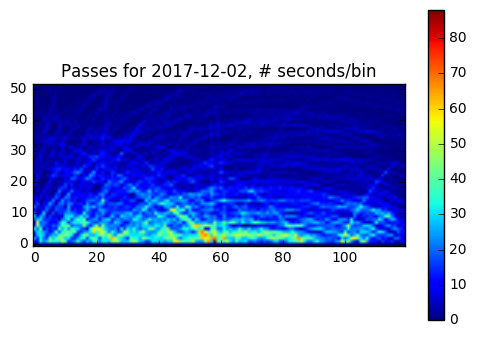

In [81]:
k = 1

seconds_bins = np.zeros_like(bins)

for ssn, alt, az, rng, dt in results[k]:
    alt_i = int(alt) - alt_degs[0]
    az_i = int(az) - az_degs[0]
    
    seconds_bins[alt_i,az_i] += 1

imshow(seconds_bins, origin="bottom")
colorbar()
title("Passes for %s, # seconds/bin" % (dt0+datetime.timedelta(days=k)).strftime("%Y-%m-%d"))


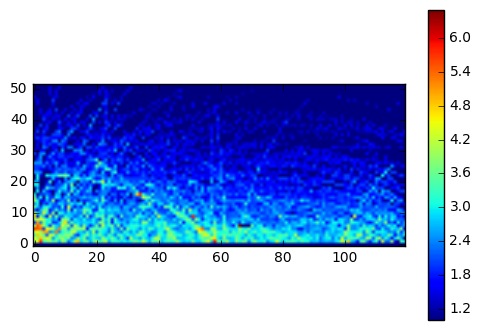

In [83]:
imshow((1+seconds_bins)/(1+bins), origin='bottom')
colorbar()

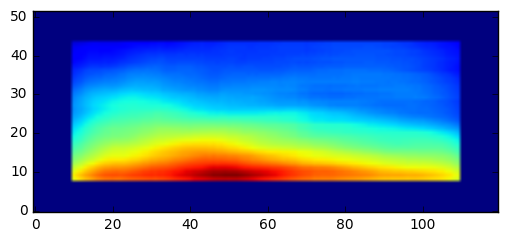

In [88]:
def window_sums(b, w, h):
    sums = np.zeros_like(b)
    for y in range(b.shape[0] - h/2):
        for x in range(b.shape[1] - w/2):
            sums[y,x] = np.sum(b[y-h/2:y+h/2,x-w/2:x+w/2])
            
    return sums

imshow(window_sums(bins, 20, 16), origin='bottom')

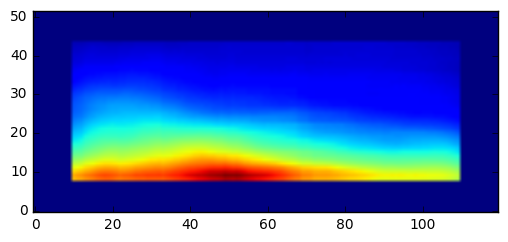

In [89]:
imshow(window_sums(seconds_bins, 20, 16), origin='bottom')